# K-fold cross validation - Regression Model
Based on the [Ludwig regression example](https://uber.github.io/ludwig/examples/#simple-regression-fuel-efficiency-prediction)

This example demonstrates teh following:
* Download a data set and create a pandas dataframe
* create a training and hold-out test data sets
* Create a Ludwig model definition data structure from the pandas dataframe
* Run a 5-fold cross validation analysis with the training data
* Use Ludwig APIs to train and assess model performance on hold-out test data set

In [1]:
import logging
import os
import os.path
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

from ludwig.api import kfold_cross_validate, LudwigModel

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Contstants

In [2]:
DATA_SET_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
DATA_SET = 'auto_mpg.data'
RESULTS_DIR = 'results'

## Clean out previous results

In [3]:
if os.path.isfile(DATA_SET):
    os.remove(DATA_SET)
    
shutil.rmtree(RESULTS_DIR, ignore_errors=True)

## Retrieve data from UCI Machine Learning Repository

### Download required data

In [4]:
r = requests.get(DATA_SET_URL)
if r.status_code == 200:
    with open(DATA_SET,'w') as f:
        f.write(r.content.decode("utf-8"))

### create pandas dataframe from downloaded data

In [5]:

raw_df = pd.read_csv(DATA_SET,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_df.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']

In [6]:
raw_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,15.0,8,350.0,165.0,3693.0,11.5,70,1
1,18.0,8,318.0,150.0,3436.0,11.0,70,1
2,16.0,8,304.0,150.0,3433.0,12.0,70,1
3,17.0,8,302.0,140.0,3449.0,10.5,70,1
4,15.0,8,429.0,198.0,4341.0,10.0,70,1


### Create train/test split

In [7]:
train_df, test_df = train_test_split(raw_df, train_size=0.8, random_state=17)
print(train_df.shape)
print(test_df.shape)

(317, 8)
(80, 8)


## setup ludwig model definition

In [8]:
num_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear']
cat_features = ['Origin']

### Create ludwig input_features

In [9]:
input_features = []
# setup input features for numerical variables
for p in num_features:
    a_feature = {'name': p, 'type': 'numerical', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    input_features.append(a_feature)

# setkup input features for categorical variables
for p in cat_features:
    a_feature = {'name': p, 'type': 'category'}

### Create ludwig output features

In [10]:
output_features =[
    {
        'name': 'MPG',
        'type': 'numerical',
        'num_fc_layers': 2,
        'fc_size': 64
    }
]

In [11]:
model_definition = {
    'input_features' : input_features,
    'output_features': output_features,
    'training' :{
        'epochs': 100,
        'batch_size': 32
    }
}
model_definition

{'input_features': [{'name': 'Cylinders',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Displacement',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Horsepower',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Weight',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Acceleration',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'ModelYear',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}}],
 'output_features': [{'name': 'MPG',
   'type': 'numerical',
   'num_fc_layers': 2,
   'fc_size': 64}

## Perform k-fold cv analysis

In [12]:
%%time
with tempfile.TemporaryDirectory() as tmpdir:
    data_csv_fp = os.path.join(tmpdir,'train.csv')
    train_df.to_csv(data_csv_fp, index=False)

    (
        kfold_cv_stats, 
        kfold_split_indices 
    ) = kfold_cross_validate(
        5,
        model_definition=model_definition,
        data_csv=data_csv_fp,
        output_directory=tmpdir,
        logging_level='error'
    )


starting 5-fold cross validation
training on fold 1
Experiment name: cross_validation
Model name: fold_1
Output path: /tmp/tmpfw1plg18/tmpxzt6dbte/results/cross_validation_fold_1


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-30b25dfd-9b49-414c-bc7d-065d9848fb50.json')
commit_hash: '3a2d1e09cdcf'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'Cylinders',
                              'preprocessing': {   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'Displacement',
                              'preprocessing': {   'missing_value_strategy': 'fill_with_mean',
                                                   'no



Using training dataframe
Building dataset (it may take a while)
Training set: 253
Test set: 64

╒══════════╕
│ TRAINING │
╘══════════╛



Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 496.84it/s]
Took 0.2476s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 656.8946 │             656.8946 │               24.2437 │ -0.2987 │ 24.2437 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 619.1349 │             619.1349 │               23.7692 │ -0.3607 │ 23.7692 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 453.90it/s]
Took 0.6434s
╒═══════╤══════════╤══════════════════════╤═══════════════════════



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 511.00it/s]
Took 0.5016s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 42.8630 │              42.8630 │                5.2363 │ 0.0101 │  1.5295 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 35.2154 │              35.2154 │                4.8082 │ 0.0088 │  0.2265 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 403.16it/s]
Took 0.5140s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 484.95it/s]
Took 0.4521s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 24.6343 │              24.6343 │                3.7430 │ 0.0193 │  0.9035 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 23.3784 │              23.3784 │                3.6078 │ 0.0162 │ -0.2799 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  22
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 462.90it/s]
Took 0.4520s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 573.34it/s]
Took 0.4388s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 19.1031 │              19.1031 │                3.2616 │ 0.0221 │  0.6105 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 20.3564 │              20.3564 │                3.2812 │ 0.0182 │ -0.5226 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 560.62it/s]
Took 0.4449s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 580.25it/s]
Took 0.4526s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 16.2263 │              16.2263 │                3.0094 │ 0.0235 │  0.4563 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 18.3888 │              18.3888 │                3.1066 │ 0.0195 │ -0.6015 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  42
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 488.62it/s]
Took 0.4415s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 605.89it/s]
Took 0.4283s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 14.3312 │              14.3312 │                2.8171 │ 0.0245 │  0.3677 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 16.6361 │              16.6361 │                2.9632 │ 0.0206 │ -0.6261 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 461.95it/s]
Took 0.4439s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 558.53it/s]
Took 0.4483s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 12.8814 │              12.8814 │                2.6586 │ 0.0252 │  0.3044 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.0171 │              15.0171 │                2.8073 │ 0.0216 │ -0.6364 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  62
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 600.64it/s]
Took 0.4312s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 569.88it/s]
Took 0.4518s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.7622 │              11.7622 │                2.5259 │ 0.0257 │  0.2511 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 13.6192 │              13.6192 │                2.6559 │ 0.0225 │ -0.6416 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 703.74it/s]
Took 0.4240s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 545.96it/s]
Took 0.4564s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.8906 │              10.8906 │                2.4232 │ 0.0262 │  0.2099 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 12.5433 │              12.5433 │                2.5299 │ 0.0232 │ -0.6390 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  82
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 536.08it/s]
Took 0.4777s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 607.61it/s]
Took 0.4485s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.0731 │              10.0731 │                2.3350 │ 0.0266 │  0.1778 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 11.6529 │              11.6529 │                2.4139 │ 0.0237 │ -0.6261 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 549.64it/s]
Took 0.4627s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 52.86it/s]
training on fold 2
Experiment name: cross_validation
Model name: fold_2
Output path: /tmp/tmpfw1plg18/tmpfvqyl_v4/results/cross_validation_fold_2


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-30b25dfd-9b49-414c-bc7d-065d9848fb50.json')
commit_hash: '3a2d1e09cdcf'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'Cylinders',
                              'preprocessing': {   'fill_value': 0,
                                                   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'Displacement',
                              'preprocessing': {   'fill



Using training dataframe
Building dataset (it may take a while)
Training set: 253
Test set: 64

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 410.56it/s]
Took 0.2126s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 646.3637 │             646.3637 │               24.0943 │ -0.3221 │ 24.0943 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 665.5875 │             665.5875 │               24.5073 │ -0.3144 │ 24.5073 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 367.47it/s]
Took 0.5106s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 398.60it/s]
Took 0.5219s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 42.0658 │              42.0658 │                5.2594 │ 0.0081 │  1.4462 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 41.5474 │              41.5474 │                4.9939 │ 0.0082 │  1.6341 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 400.62it/s]
Took 0.5318s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 569.61it/s]
Took 0.4719s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 25.9599 │              25.9599 │                3.8342 │ 0.0172 │  0.9323 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 23.6624 │              23.6624 │                3.6162 │ 0.0177 │  1.3561 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  22
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 531.90it/s]
Took 0.4905s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 608.09it/s]
Took 0.4700s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 20.8229 │              20.8229 │                3.3651 │ 0.0201 │  0.6663 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 17.8573 │              17.8573 │                3.1304 │ 0.0210 │  1.0896 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 648.07it/s]
Took 0.4555s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 591.83it/s]
Took 0.4380s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 17.7616 │              17.7616 │                3.0974 │ 0.0218 │  0.5082 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 14.7180 │              14.7180 │                2.8883 │ 0.0229 │  0.8624 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  42
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 573.89it/s]
Took 0.4189s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 591.46it/s]
Took 0.4422s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 15.6585 │              15.6585 │                2.9000 │ 0.0230 │  0.4126 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 12.6471 │              12.6471 │                2.7011 │ 0.0241 │  0.7071 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 533.56it/s]
Took 0.4380s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 612.62it/s]
Took 0.4339s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 14.0332 │              14.0332 │                2.7281 │ 0.0239 │  0.3395 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 11.1377 │              11.1377 │                2.5278 │ 0.0250 │  0.6092 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  62
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 601.98it/s]
Took 0.4403s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 447.18it/s]
Took 0.4397s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 12.7179 │              12.7179 │                2.5871 │ 0.0247 │  0.2795 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 10.0247 │              10.0247 │                2.4119 │ 0.0257 │  0.5289 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 525.37it/s]
Took 0.4371s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 577.85it/s]
Took 0.4446s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.6318 │              11.6318 │                2.4670 │ 0.0253 │  0.2383 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │  9.1465 │               9.1465 │                2.3224 │ 0.0262 │  0.4778 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  82
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 516.25it/s]
Took 0.4287s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 639.57it/s]
Took 0.4262s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.7518 │              10.7518 │                2.3649 │ 0.0258 │  0.2021 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │  8.4647 │               8.4647 │                2.2538 │ 0.0266 │  0.4314 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 512.22it/s]
Took 0.4539s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 54.90it/s]
training on fold 3
Experiment name: cross_validation
Model name: fold_3
Output path: /tmp/tmpfw1plg18/tmpfoqpvrgv/results/cross_validation_fold_3


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-30b25dfd-9b49-414c-bc7d-065d9848fb50.json')
commit_hash: '3a2d1e09cdcf'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'Cylinders',
                              'preprocessing': {   'fill_value': 0,
                                                   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'Displacement',
                              'preprocessing': {   'fill



Using training dataframe
Building dataset (it may take a while)
Training set: 254
Test set: 63

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 431.27it/s]
Took 0.2139s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 639.3220 │             639.3220 │               23.9823 │ -0.3127 │ 23.9823 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 694.7713 │             694.7713 │               24.9315 │ -0.3129 │ 24.9315 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 466.29it/s]
Took 0.5053s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 429.92it/s]
Took 0.5464s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 42.1779 │              42.1779 │                5.2424 │ 0.0085 │  1.5941 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 42.1194 │              42.1194 │                5.3033 │ 0.0087 │  2.6711 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 488.33it/s]
Took 0.4782s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 588.22it/s]
Took 0.4485s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 23.4006 │              23.4006 │                3.6089 │ 0.0187 │  0.9268 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 31.8216 │              31.8216 │                4.2133 │ 0.0136 │  1.7810 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  22
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 533.80it/s]
Took 0.4513s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 600.39it/s]
Took 0.4384s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 18.2511 │              18.2511 │                3.1387 │ 0.0215 │  0.6721 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 27.6353 │              27.6353 │                3.8874 │ 0.0160 │  1.3482 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 603.06it/s]
Took 0.4385s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 405.48it/s]
Took 0.5092s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 15.2142 │              15.2142 │                2.8548 │ 0.0231 │  0.5089 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 24.2107 │              24.2107 │                3.6551 │ 0.0180 │  1.0479 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  42
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 645.43it/s]
Took 0.4221s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 545.10it/s]
Took 0.4464s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 13.0712 │              13.0712 │                2.6454 │ 0.0243 │  0.4131 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 21.8284 │              21.8284 │                3.4640 │ 0.0195 │  0.8772 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 542.39it/s]
Took 0.4528s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 618.22it/s]
Took 0.4346s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.3399 │              11.3399 │                2.4547 │ 0.0253 │  0.3308 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 20.1076 │              20.1076 │                3.2721 │ 0.0206 │  0.7530 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  62
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 644.04it/s]
Took 0.4276s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 476.60it/s]
Took 0.4437s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.0772 │              10.0772 │                2.3160 │ 0.0260 │  0.2670 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 18.8996 │              18.8996 │                3.1279 │ 0.0214 │  0.6696 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 603.06it/s]
Took 0.4337s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 653.22it/s]
Took 0.4252s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │  9.2001 │               9.2001 │                2.2232 │ 0.0265 │  0.2238 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 18.0872 │              18.0872 │                3.0239 │ 0.0219 │  0.6077 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  82
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 668.20it/s]
Took 0.4421s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 644.34it/s]
Took 0.4600s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │  8.5436 │               8.5436 │                2.1611 │ 0.0268 │  0.1902 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 17.4273 │              17.4273 │                2.9511 │ 0.0222 │  0.5436 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 639.96it/s]
Took 0.4451s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 51.65it/s]
training on fold 4
Experiment name: cross_validation
Model name: fold_4
Output path: /tmp/tmpfw1plg18/tmpr48wbpjz/results/cross_validation_fold_4


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-30b25dfd-9b49-414c-bc7d-065d9848fb50.json')
commit_hash: '3a2d1e09cdcf'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'Cylinders',
                              'preprocessing': {   'fill_value': 0,
                                                   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'Displacement',
                              'preprocessing': {   'fill



Using training dataframe
Building dataset (it may take a while)
Training set: 254
Test set: 63

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 471.46it/s]
Took 0.2225s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 647.7216 │             647.7216 │               24.0803 │ -0.3236 │ 24.0803 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 658.4239 │             658.4239 │               24.4741 │ -0.3383 │ 24.4741 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 404.80it/s]
Took 0.5076s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 333.07it/s]
Took 0.5342s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 42.2915 │              42.2915 │                5.2758 │ 0.0084 │  1.3496 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 44.6649 │              44.6649 │                5.2852 │ 0.0074 │  2.0655 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 419.89it/s]
Took 0.4432s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 525.40it/s]
Took 0.4723s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 25.1016 │              25.1016 │                3.7903 │ 0.0174 │  0.8689 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 25.8950 │              25.8950 │                3.6356 │ 0.0176 │  1.5057 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  22
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 499.23it/s]
Took 0.4587s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 599.96it/s]
Took 0.4456s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 20.0029 │              20.0029 │                3.3251 │ 0.0203 │  0.6466 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 19.3319 │              19.3319 │                3.1585 │ 0.0212 │  1.3385 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 482.91it/s]
Took 0.4592s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 621.61it/s]
Took 0.4346s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 17.0949 │              17.0949 │                3.0641 │ 0.0219 │  0.5065 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.6939 │              15.6939 │                2.9057 │ 0.0232 │  1.2481 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  42
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 599.02it/s]
Took 0.4455s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 602.28it/s]
Took 0.4362s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 15.0849 │              15.0849 │                2.8715 │ 0.0231 │  0.4260 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 13.3448 │              13.3448 │                2.6840 │ 0.0245 │  1.1895 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 464.36it/s]
Took 0.4410s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 533.86it/s]
Took 0.4665s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 13.5987 │              13.5987 │                2.7252 │ 0.0240 │  0.3602 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 11.6644 │              11.6644 │                2.4952 │ 0.0254 │  1.1229 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  62
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 501.56it/s]
Took 0.4516s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 621.56it/s]
Took 0.4524s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 12.4639 │              12.4639 │                2.6106 │ 0.0246 │  0.3103 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 10.4777 │              10.4777 │                2.3432 │ 0.0261 │  1.0781 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 473.83it/s]
Took 0.4624s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 548.60it/s]
Took 0.4696s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.5640 │              11.5640 │                2.5075 │ 0.0251 │  0.2772 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │  9.6238 │               9.6238 │                2.2567 │ 0.0265 │  1.0558 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  82
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 489.13it/s]
Took 0.4764s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 507.94it/s]
Took 0.4426s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.8288 │              10.8288 │                2.4119 │ 0.0255 │  0.2531 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │  8.9430 │               8.9430 │                2.1834 │ 0.0269 │  1.0278 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 584.73it/s]
Took 0.4129s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 51.63it/s]
training on fold 5
Experiment name: cross_validation
Model name: fold_5
Output path: /tmp/tmpfw1plg18/tmp6b_i54fi/results/cross_validation_fold_5


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-30b25dfd-9b49-414c-bc7d-065d9848fb50.json')
commit_hash: '3a2d1e09cdcf'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'Cylinders',
                              'preprocessing': {   'fill_value': 0,
                                                   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'Displacement',
                              'preprocessing': {   'fill



Using training dataframe
Building dataset (it may take a while)
Training set: 254
Test set: 63

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 522.98it/s]
Took 0.2182s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 659.7176 │             659.7176 │               24.4274 │ -0.3392 │ 24.4274 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 612.9737 │             612.9737 │               23.1627 │ -0.2506 │ 23.1627 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 387.52it/s]
Took 0.5239s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 491.74it/s]
Took 0.5116s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 41.5493 │              41.5493 │                5.1622 │ 0.0081 │  1.2432 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 53.1855 │              53.1855 │                6.1484 │ 0.0077 │  0.7313 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 538.01it/s]
Took 0.5060s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 484.25it/s]
Took 0.4441s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 25.3065 │              25.3065 │                3.7484 │ 0.0172 │  0.9338 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 28.0881 │              28.0881 │                4.2131 │ 0.0191 │  0.3102 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  22
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 576.62it/s]
Took 0.4356s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 630.53it/s]
Took 0.4548s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 19.6477 │              19.6477 │                3.2669 │ 0.0205 │  0.6681 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 21.8039 │              21.8039 │                3.5322 │ 0.0219 │  0.0944 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 525.17it/s]
Took 0.4717s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 588.92it/s]
Took 0.4702s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 16.3029 │              16.3029 │                2.9866 │ 0.0224 │  0.4957 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 19.2981 │              19.2981 │                3.2166 │ 0.0230 │ -0.0461 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  42
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 615.45it/s]
Took 0.4697s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 516.51it/s]
Took 0.4418s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 13.9940 │              13.9940 │                2.7698 │ 0.0237 │  0.3800 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 18.0207 │              18.0207 │                3.1116 │ 0.0236 │ -0.1696 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 557.98it/s]
Took 0.4575s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 509.08it/s]
Took 0.4348s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 12.4032 │              12.4032 │                2.6008 │ 0.0246 │  0.3042 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 16.9578 │              16.9578 │                3.0633 │ 0.0240 │ -0.2478 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  62
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 529.02it/s]
Took 0.4303s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 435.95it/s]
Took 0.4674s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.2151 │              11.2151 │                2.4718 │ 0.0253 │  0.2610 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.8807 │              15.8807 │                2.9709 │ 0.0245 │ -0.2856 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 617.81it/s]
Took 0.4496s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 458.72it/s]
Took 0.4602s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.3041 │              10.3041 │                2.3653 │ 0.0258 │  0.2183 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.0875 │              15.0875 │                2.8905 │ 0.0248 │ -0.3028 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  82
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 447.97it/s]
Took 0.4989s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 420.02it/s]
Took 0.4702s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │  9.5735 │               9.5735 │                2.2762 │ 0.0262 │  0.1871 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 14.4527 │              14.4527 │                2.8148 │ 0.0251 │ -0.3234 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 410.76it/s]
Took 0.4428s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 48.41it/s]
completed 5-fold cross validation
CPU times: user 1min 15s, sys: 8.41 s, total: 1min 24s
Wall time: 1min 16s


In [13]:
kfold_cv_stats['overall']['MPG']

{'loss_mean': 11.656174600692022,
 'loss_std': 3.385989019349111,
 'mean_squared_error_mean': 11.656174600692022,
 'mean_squared_error_std': 3.385989019349111,
 'mean_absolute_error_mean': 2.4628408394162618,
 'mean_absolute_error_std': 0.308747924671152,
 'r2_mean': 0.025212093569811373,
 'r2_std': 0.0017364260163436956,
 'error_mean': 0.18935876450841388,
 'error_std': 0.5842496762755447}

## Train model and assess model performance

In [14]:
model = LudwigModel(
    model_definition=model_definition,
    logging_level=logging.ERROR
)

In [15]:
%%time
training_stats = model.train(
    data_train_df=train_df,
    output_directory=RESULTS_DIR,
)

CPU times: user 14.4 s, sys: 1.27 s, total: 15.7 s
Wall time: 18.9 s


In [16]:
mpg_hat_df, test_stats = model.test(data_df=test_df)

/opt/project/ludwig/data/preprocessing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[feature['name']].mean(),
/opt/project/ludwig/data/preprocessing.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessing_parameters['fill_value'],


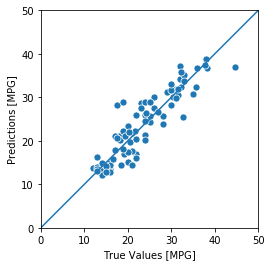

In [17]:
a = plt.axes(aspect='equal')
sns.scatterplot(test_df['MPG'].values, mpg_hat_df['MPG_predictions'].values,
               s=50)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## Compare k-fold CV metrics against hold-out test metrics

### Hold-out Test Metrics

In [18]:
test_stats['MPG']

{'loss': 11.207579040527344,
 'mean_squared_error': 11.207579040527344,
 'mean_absolute_error': 2.5836021423339846,
 'r2': 0.009923791885375977,
 'error': -0.19772685766220094}

### K-fold CV Metrics

In [19]:
kfold_cv_stats['overall']['MPG']

{'loss_mean': 11.656174600692022,
 'loss_std': 3.385989019349111,
 'mean_squared_error_mean': 11.656174600692022,
 'mean_squared_error_std': 3.385989019349111,
 'mean_absolute_error_mean': 2.4628408394162618,
 'mean_absolute_error_std': 0.308747924671152,
 'r2_mean': 0.025212093569811373,
 'r2_std': 0.0017364260163436956,
 'error_mean': 0.18935876450841388,
 'error_std': 0.5842496762755447}